# How to Structure from Motion

## Authors: Muneeb Aadil, Sibt Ul Hussain

In [1]:
#loading needed libraries 
import utils as ut 
import SfM as sfmnp

import matplotlib.pyplot as plt 

from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

import sys

#auto-reloading external modules
%load_ext autoreload
%autoreload 2

# Set the default behavior
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False


# Chapter 1. Prerequisites

## 1.1. Transformations

## 1.2. Camera Models 

## 1.3 RANSAC

# Chapter 2. Epipolar Geometry

## Reading a pair of images, and comparing AKAZE matches

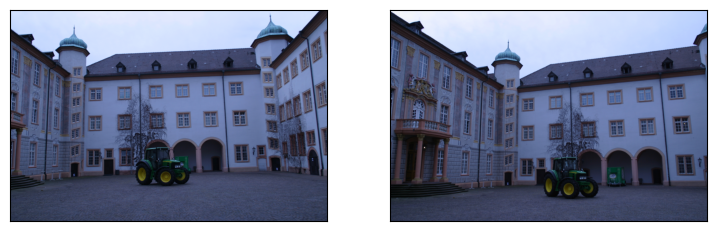

In [2]:
#Reading two images for reference
img1 = cv2.imread("../tutorial/data/castle-P30/images/0001.jpg")
img2 = cv2.imread("../tutorial/data/castle-P30/images/0002.jpg")

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [3]:
akaze = cv2.AKAZE_create()

# Detecting keypoints and computing descriptors
kp1, desc1 = akaze.detectAndCompute(img1, None)
kp2, desc2 = akaze.detectAndCompute(img2, None)

# Creating BFMatcher object
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Matching descriptors
matches = matcher.match(desc1, desc2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=ut.GetAlignedMatchesAKAZE(kp1,kp2,matches)


## 2.2. Fundamental Matrix Computation



### with RANSAC (Random Sample Consensus)

In [43]:
F, mask = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,ransacReprojThreshold=0.1)
mask=mask.astype(bool).flatten()
print(len(mask))
print(F)

2982
[[-7.77567683e-09 -2.56152797e-07  4.11257517e-04]
 [ 7.22731633e-07  7.44202903e-08 -5.85621344e-03]
 [-1.04192931e-03  5.34994561e-03  1.00000000e+00]]
2982
2982


## 2.2. Epipolar Lines Computation

In [5]:
lines1=cv2.computeCorrespondEpilines(img1pts,2,F).reshape(-1,3)
lines2=cv2.computeCorrespondEpilines(img2pts,1,F).reshape(-1,3)

## 2.4. Visualizations I: Epipolar Geometry
### 2.4.1. Epipolar Lines

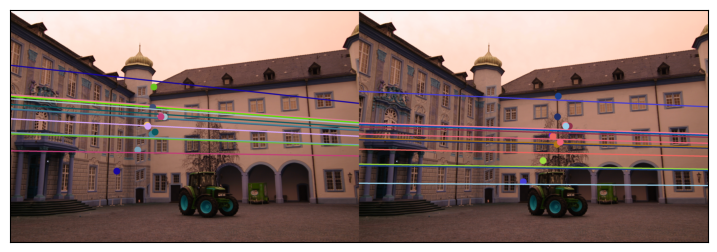

In [6]:
def drawlines(img1,lines,pts1,linesize=3,circlesize=10,drawOnly=10):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:-1]

    img1_ = np.copy(img1)


    for i,(r,pt1) in enumerate(zip(lines,pts1)):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        
        img1_ = cv2.line(img1_, (x0,y0), (x1,y1), color,linesize)
        img1_ = cv2.circle(img1_,tuple(pt1.astype(int)),circlesize,color,-1)

        if i>drawOnly:
            break

    return img1_

img_epiline1 = drawlines(img2,lines1,img1pts[mask] ,linesize=10,circlesize=30)
img_epiline2 = drawlines(img2,lines2,img2pts[mask] ,linesize=10,circlesize=30)
concatenated_images = cv2.hconcat([img_epiline1, img_epiline2])

# Convert the image from BGR to RGB format
concatenated_images = cv2.cvtColor(concatenated_images, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(9,4))
plt.imshow(concatenated_images)
plt.show()




## 2.5. Pose Estimation

In [7]:
#intrinsic parameter of camera
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])

E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 2.6. Visualizations II: Camera Poses

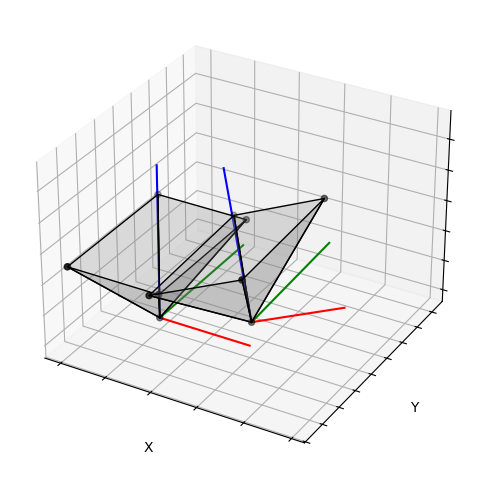

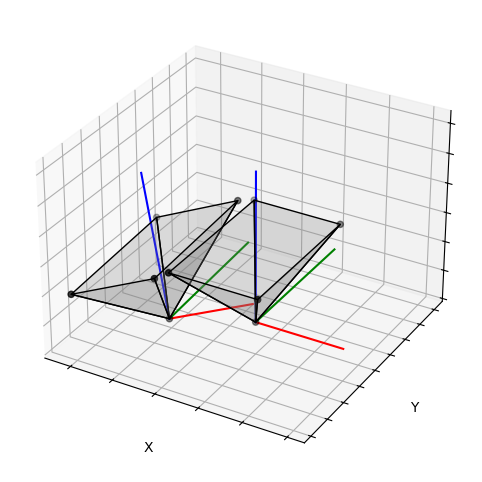

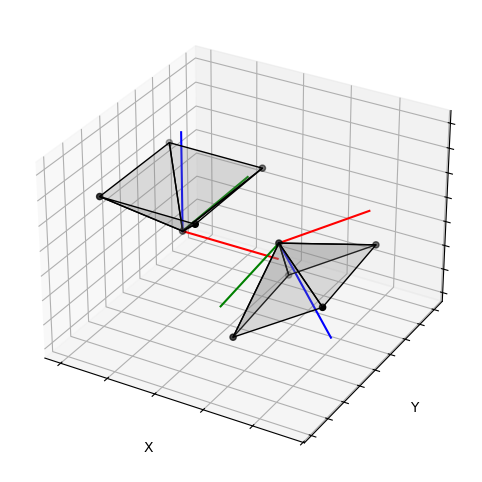

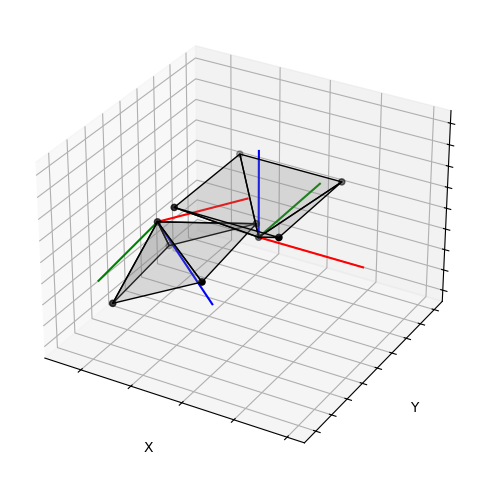

In [8]:
for R_ in [R1,R2]: 
    for t_ in [t,-t]:
        
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        ut.PlotCamera(R_,t_[:,0],ax)

# Chapter 3. 3D Scene Estimations

## 3.1. Triangulation: DLT Method 

In [9]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [10]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t)


## 3.2. Visualizing the triangulated points of configurations

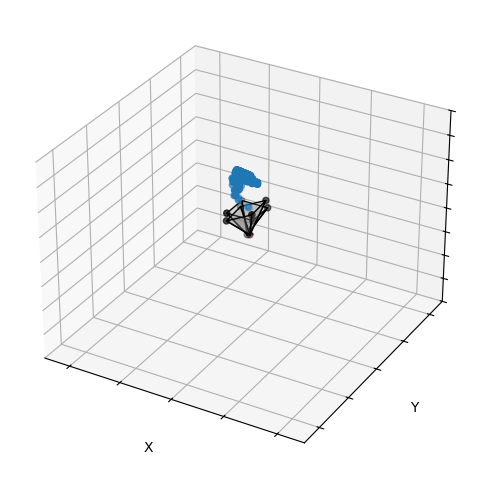

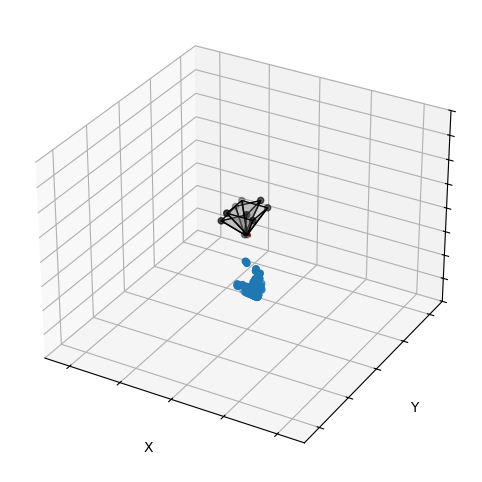

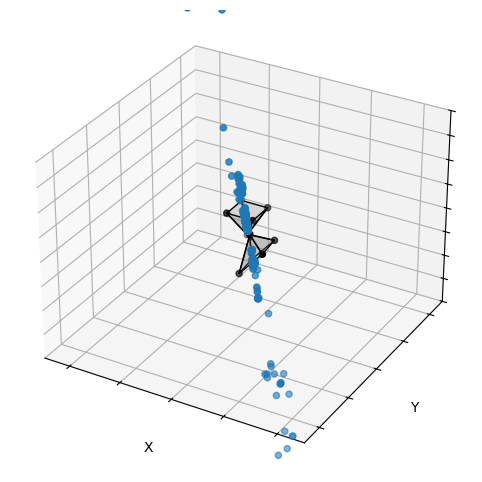

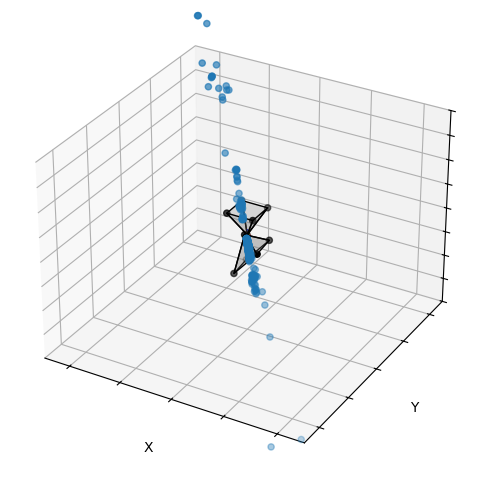

In [11]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t))

for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## 3.3. Camera Pose Disambiguation

In [12]:
_,R,t,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)


## 3.4. Visualizing Point Cloud Output

In [13]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t)
ut.pts2ply(pts3d,'castle_2view.ply')

In [14]:
def visualize_3d_data(pts3d):
    if 'o3d' not in sys.modules:
        import open3d as o3d

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts3d)

    # Create a visualizer object
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=800, height=600)

    # Add the point cloud to the visualizer
    vis.add_geometry(pcd)

    # Start the visualization
    vis.run()

    # Destroy the window after use
    vis.destroy_window()


In [15]:
Visualize_3d_data=True

if Visualize_3d_data:
    visualize_3d_data(pts3d)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 3. Reprojection Error: Evaluation

## Computation

In [16]:
def compute_reprojection_error(pts3d, R1, t1, R2, t2, img1pts, img2pts, mask, K):
    # Project the 3D points back to 2D using the rotation and translation matrices
    img1ptsReproj, _ = cv2.projectPoints(pts3d, R1, t1, K, distCoeffs=None)
    img2ptsReproj, _ = cv2.projectPoints(pts3d, R2, t2, K, distCoeffs=None)

    # Reshape the reprojected points
    img1ptsReproj = img1ptsReproj.reshape(-1, 2)
    img2ptsReproj = img2ptsReproj.reshape(-1, 2)

    img1ptsReproj = img1ptsReproj.reshape(-1, 2)
    img2ptsReproj = img2ptsReproj.reshape(-1, 2)

    # Compute the error as the Euclidean distance between the original and reprojected points
    err1 = np.sqrt(np.sum((img1pts[mask] - img1ptsReproj)**2, axis=1)).mean()
    err2 = np.sqrt(np.sum((img2pts[mask] - img2ptsReproj)**2, axis=1)).mean()

    return err1, err2

print(compute_reprojection_error(pts3d,np.eye(3,3),np.zeros((3,1)),R,t,img1pts,img2pts,mask,K))

(0.20435406870190972, 0.20555656411480963)


## Visualization

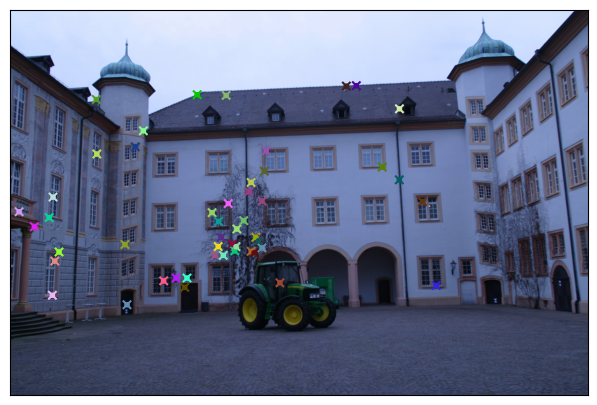

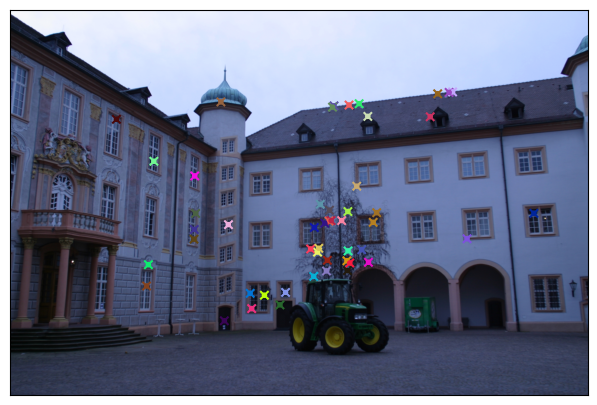

In [17]:
img1ptsReproj, _ = cv2.projectPoints(pts3d,np.eye(3,3),np.zeros((3,1)),K,distCoeffs=None)
img2ptsReproj, _ = cv2.projectPoints(pts3d,R,t,K,distCoeffs=None)

img1ptsReproj = img1ptsReproj.reshape(-1, 2)
img2ptsReproj = img2ptsReproj.reshape(-1, 2)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax)

# 4. Perspective-n-Point Algorithm: New Camera Registration

## 4.0. Reading third image and 2D-3D Matching using AKAZE

In [18]:
def Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d):
    #Picking only those descriptors for which 3D point is available
    desc1_3D = desc1[img1idx][mask]
    desc2_3D = desc2[img2idx][mask]

    # Creating BFMatcher object
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Matching descriptors between image 3 and image 1
    matches1 = matcher.match(desc3, desc1_3D)

    # Matching descriptors between image 3 and image 2
    matches2 = matcher.match(desc3, desc2_3D)

    # Merging the matches
    matches = matches1 + matches2

    # Sorting matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    #Filtering out matched 2D keypoints from new view 
    img3pts = np.array([kp3[m.queryIdx].pt for m in matches])

    #Filtering out matched 3D already triangulated points 
    pts3didx = np.array([m.trainIdx for m in matches])
    pts3d_ = pts3d[pts3didx]

    return img3pts, pts3d_

In [46]:
img3 = cv2.imread("../tutorial/data/castle-P30/images/0005.jpg")
img3 = img3[:,:,::-1]

kp3, desc3 = akaze.detectAndCompute(img3,None)
desc1_3D = desc1[img1idx][mask]
desc2_3D = desc2[img2idx][mask]
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Matching descriptors between image 3 and image 1
matches1 = matcher.match(desc3, desc1_3D)

# Matching descriptors between image 3 and image 2   
matches2 = matcher.match(desc3, desc2_3D)

# Merging the matches
matches = matches1 + matches2
img2pts,img3pts,img2idx,pts3dpts=ut.GetAlignedMatchesAKAZE(kp2,kp3,matches)
#img3pts,pts3dpts = Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

plt.imshow(img3, cmap='gray')
colors = colors=np.random.rand(len(img3pts),3)
plt.scatter(img3pts[:, 0], img3pts[:, 1],marker='x',c=colors)
plt.show()


IndexError: index 7066 is out of bounds for axis 0 with size 6046

## 4.1. Perspective-n-Point (PnP) Algorithm

### 4.1.1. Least Squares Solution

### 4.1.2. RANSAC

In [20]:


retval,Rvec,tnew,mask3gt = cv2.solvePnPRansac(pts3dpts,img3pts,K,None,confidence=.99,flags=cv2.SOLVEPNP_ITERATIVE)
Rnew,_=cv2.Rodrigues(Rvec)

print(tnew)
print(Rnew)

if not retval: 
    raise Exception("PnP failed to converge")


[[-3.7262556 ]
 [ 0.20659388]
 [ 1.10725691]]
[[ 0.70368756  0.10939149  0.70203798]
 [-0.10094769  0.99344609 -0.05361378]
 [-0.70330177 -0.03314177  0.71011847]]


## 4.2. Visualizations

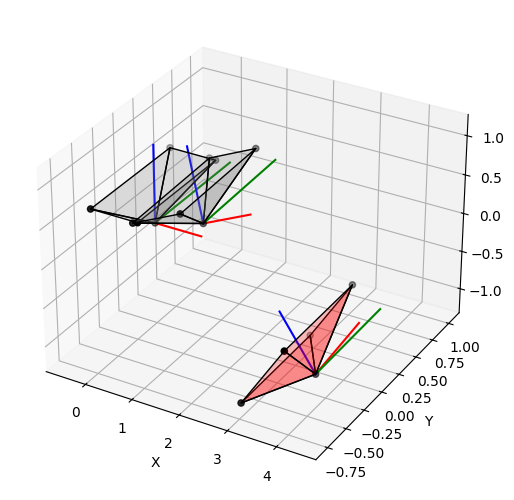

In [21]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')

# Enable the ticks on the x and y axes
ax.xaxis.set_tick_params(which='both', bottom=True, top=True, labelbottom=True)
ax.yaxis.set_tick_params(which='both', left=True, right=True, labelleft=True)
ax.zaxis.set_tick_params(which='both', left=True, right=True, labelleft=True)


#np.array([[1,0,0],[0,0,1],[0,1,0]]) correct camera orientation need to try putting it like this from the start
ut.PlotCamera(np.eye(3),np.zeros((3,)),ax)
ut.PlotCamera(R,t[:,0],ax)
ut.PlotCamera(Rnew,tnew[:,0],ax,faceColor='red')




plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)  # Adjust the subplot parameters



plt.show()

In [42]:
print(len(img2pts))
print(len(img3pts))
F, mask2 = cv2.findFundamentalMat(img2pts,img3pts,method=cv2.FM_RANSAC,ransacReprojThreshold=0.1)
mask2=mask2.astype(bool).flatten()

2982
894


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:862: error: (-215:Assertion failed) m1.checkVector(2) == m2.checkVector(2) in function 'cv::findFundamentalMat'


# 5. Re-triangulation

In [22]:

kpNew, descNew = kp3, desc3 

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]: 
    
    #Matching between old view and newly registered view.. 
    print ('[Info]: Feature Matching..')
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, img3idx = ut.GetAlignedMatchesAKAZE(kpOld,kpNew,matches)
    
    #Pruning the matches using fundamental matrix..
    print ('[Info]: Pruning the Matches..')
    F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC, ransacReprojThreshold=0.1, confidence=0.99)
    mask = mask.flatten().astype(bool)
    imgOldPts=imgOldPts[mask]
    imgNewPts=imgNewPts[mask]
    
    #Triangulating new points
    print ('[Info]: Triangulating..')
    
    newPts = sfmnp.GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew,cv2.triangulatePoints,ROld,tOld)
    
    #Adding newly triangulated points to the collection
    accPts.append(newPts)

print(type(accPts))

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
<class 'list'>


In [23]:
#Adding the original 2-view-sfm point cloud and saving the whole collection

#print("number of new points added:",len(accPts))  da aggiustare
accPts.append(pts3d)
accPts = np.array(np.concatenate(accPts,axis=0))

print(len(accPts))
ut.pts2ply(accPts,'castle_nview.ply')

722


# 6. Final Result 

In [24]:
if Visualize_3d_data:
    visualize_3d_data(pts3d)

In [25]:
def Find2D3DMatches1(all_descs, all_imgidxs, desc3, kp3, mask, pts3d):

    desc_3D = []
    matches = 0
    # Creating BFMatcher object
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for i in range(len(all_descs)):
        desc_3D.append(all_descs[i][all_imgidxs[i]][mask])
        # Matching descriptors between image 3 and matched images
        
    j = len(all_descs)
    while j == 0:            
        matches+=(matcher.match(desc3, desc_3D[j]))
        j=j-1

    matches = sorted(matches, key = lambda x:x.distance)

    # Filtering out matched 2D keypoints from new view 
    img3pts = np.array([kp3[m.queryIdx].pt for m in matches])

    # Filtering out matched 3D already triangulated points 
    pts3didx = np.array([m.trainIdx for m in matches])
    pts3d_ = pts3d[pts3didx]

    return img3pts, pts3d_

In [40]:
import glob

# Caricare tutte le immagini dalla cartella data
image_files = sorted(glob.glob('../tutorial/data/castle-P30/images/*.jpg'))  # Modificare il percorso e l'estensione se necessario
images = [cv2.imread(img_file) for img_file in image_files]
print(f'Total images: {len(images)}')

# Inizializzazione delle variabili
descr = [desc1, desc2, desc3]
keypts = [kp1, kp2, kp3]
imgidx = [img1idx, img2idx, img3idx]
pts3d = [pts3d, pts3dpts]
matcher = cv2.BFMatcher(crossCheck=True)
mask = [mask, mask3gt]
print(f'Initial accumulated points: {accPts}')

# Processare le immagini dalla quarta in poi
for i in range(3, 6):
    imgnew = images[i]
    imgNew = imgnew[:, :, ::-1]
    kpNew, descNew = akaze.detectAndCompute(imgNew, None)  # Funzione per ottenere keypoints e descriptors
    print(len(descNew))
    descr.append(descNew)
    keypts.append(kpNew)
    # Matching 2D-3D
    imgpts, pts3dpts = Find2D3DMatches1(descr, imgidx, descNew, kpNew, mask[i-2], pts3d)
    pts3d.append(pts3dpts)

    for (ROld, tOld, kpOld, descOld) in [(np.eye(3), np.zeros((3, 1)), kp1, desc1), (Rnew, tnew, keypts[i-1], descr[i-1])]:
        print('[Info]: Feature Matching..')
        matches = matcher.match(descOld, descNew)
        matches = sorted(matches, key=lambda x: x.distance)
        imgOldpts, imgNewpts, imgOldidx, imgNewidx = ut.GetAlignedMatchesAKAZE(kpOld, kpNew, matches)
        
        # Pruning dei match usando la matrice fondamentale
        print('[Info]: Pruning the Matches..')
        F, mask = cv2.findFundamentalMat(imgOldpts, imgNewpts, method=cv2.FM_RANSAC, ransacReprojThreshold=0.1, confidence=0.99)
        mask = mask.astype(bool).flatten()
        imgOldpts = imgOldpts[mask]
        imgNewpts = imgNewpts[mask]
        
        print('[Info]: Triangulating..')
        newPts = sfmnp.GetTriangulatedPts(imgOldpts, imgNewpts, K, Rnew, tnew, cv2.triangulatePoints, ROld, tOld)
        accPts.append(newPts)
    
    # Aggiornare imgidx per i nuovi punti
    imgidx.append(imgNewidx)
    print(len(mask))
    print(len(descNew))

# Concatenare tutti i punti 3D se ci sono punti validi
if accPts:
    accPts = np.concatenate(accPts, axis=0)
    print(f'Accumulated 3D points: {accPts.shape}')
    # Salvare o visualizzare i punti accumulati
    ut.pts2ply(accPts, 'out.ply')
else:
    print('[Warning]: No valid points to concatenate and save.')


Total images: 30
Initial accumulated points: []
8099


IndexError: list index out of range

# Chapter 4. Putting It Together: Part I

# Chapter 5. Bundle Adjustment

# Chapter 6. Putting It Together: Part II